<a href="https://colab.research.google.com/github/KamonohashiPerry/kaggle/blob/master/DataScienceBowl_2019_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename =  "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [2]:
!pip install kaggle

In [3]:
!kaggle competitions list

ref                                            deadline             category             reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ----------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started   Knowledge       2305           False  
titanic                                        2030-01-01 00:00:00  Getting Started   Knowledge      16013            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started   Knowledge       5252            True  
connectx                                       2030-01-01 00:00:00  Getting Started   Knowledge        287           False  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research          Knowledge         62           False  
competitive-data-science-predict-future-sales  2020-12-31 23:59:00  Playground            Kudos       5492            True  


In [4]:
!kaggle competitions download -c data-science-bowl-2019

  0% 0.00/262k [00:00<?, ?B/s]
100% 262k/262k [00:00<00:00, 98.2MB/s]
 94% 373M/397M [00:01<00:00, 212MB/s]
100% 397M/397M [00:01<00:00, 211MB/s]
  0% 0.00/10.8k [00:00<?, ?B/s]
100% 10.8k/10.8k [00:00<00:00, 11.1MB/s]
  0% 0.00/399k [00:00<?, ?B/s]
100% 399k/399k [00:00<00:00, 129MB/s]
100% 40.8M/40.8M [00:00<00:00, 77.1MB/s]



In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from IPython.display import HTML
import warnings

pd.set_option('max_columns', 100)
pd.set_option('max_colwidth', 200)
pd.set_option('max_rows', 200)

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
my_pal = sns.color_palette(n_colors=10)

In [0]:
specs = pd.read_csv('specs.csv')
ss = pd.read_csv('sample_submission.csv')

In [0]:
# ほとんど同じ内容のeventのinfoがあったので一つに統合する。
specs["info_fixed"] = specs["info"].str.replace('"', '')
specs["info_fixed"] = specs["info_fixed"].str.replace(' ', '')

In [8]:
specs[~specs['info_fixed'].duplicated(keep="first")].reset_index(drop=True).shape

(162, 4)

In [0]:
specs_unique = specs[~specs['info_fixed'].duplicated(keep="first")].reset_index(drop=True)

In [10]:
specs_unique.shape

(162, 4)

In [0]:
specs_id_list = pd.merge(specs, specs_unique, on="info_fixed",how="left")

In [0]:
specs_id_list = specs_id_list[["event_id_x", "event_id_y"]]
specs_id_list.columns = ["event_id", "event_id_unique"]

## jsonの前処理データを読み込む

In [0]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


In [0]:
# # drive mean root directory of  google drive
# !mkdir -p drive
# !google-drive-ocamlfuse drive
# !ls drive/"Colab Notebooks"/Kaggle

In [0]:
# train = pd.read_csv('drive/Colab Notebooks/Kaggle/train_json_preprocessed.csv.gz')

train = pd.read_csv('/content/train.csv.zip')

In [0]:
for column in train.columns:
    if train[column].dtype == 'float64':
        train[column] = train[column].astype(np.float32)
    if train[column].dtype == 'int64':
        train[column] = train[column].astype(np.int32)

In [0]:
# test = pd.read_csv('drive/Colab Notebooks/Kaggle/test_json_preprocessed.csv.gz')

test = pd.read_csv('/content/test.csv.zip')

In [0]:
for column in test.columns:
    if test[column].dtype == 'float64':
        test[column] = test[column].astype(np.float32)
    if test[column].dtype == 'int64':
        test[column] = test[column].astype(np.int32)

In [17]:
train.shape

(11341042, 11)

In [18]:
test.shape

(1156414, 11)

In [0]:
train = train.merge(specs_id_list, on="event_id", how="left")
test = test.merge(specs_id_list, on="event_id", how="left")

In [0]:
train_labels = pd.read_csv('train_labels.csv.zip')

In [21]:
train_labels.head(3)

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3


# Visualization

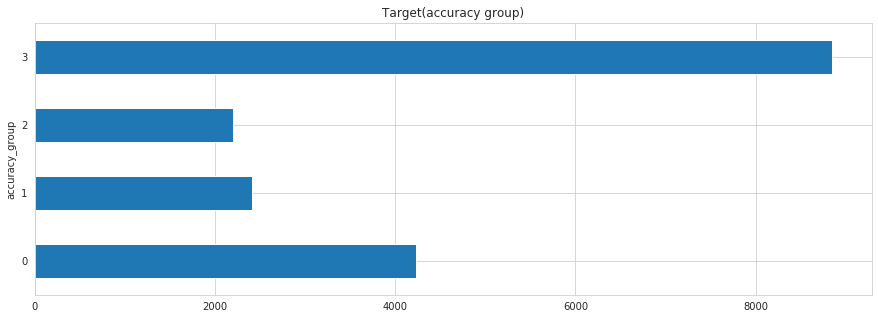

In [17]:
train_labels.groupby('accuracy_group')['game_session'].count().plot(kind='barh', figsize=(15, 5), title='Target(accuracy group)')
plt.show()

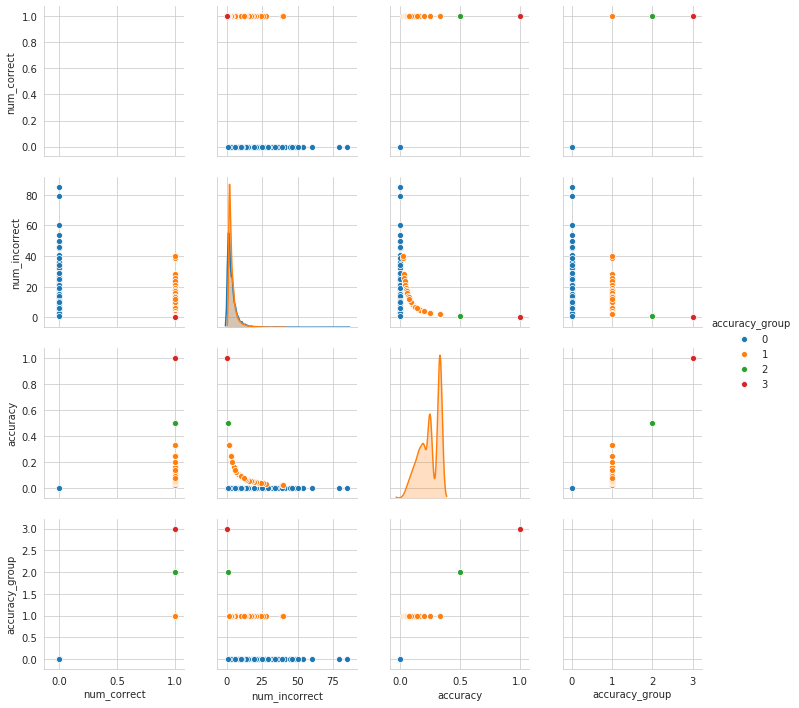

In [18]:
sns.pairplot(train_labels, hue='accuracy_group')
plt.show()

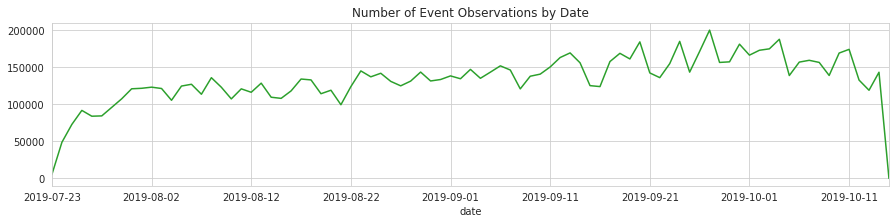

In [19]:
train.groupby('date')['event_id'].agg('count').plot(figsize=(15, 3),
                                                    title='Number of Event Observations by Date',
                                                    color=my_pal[2])
plt.show()

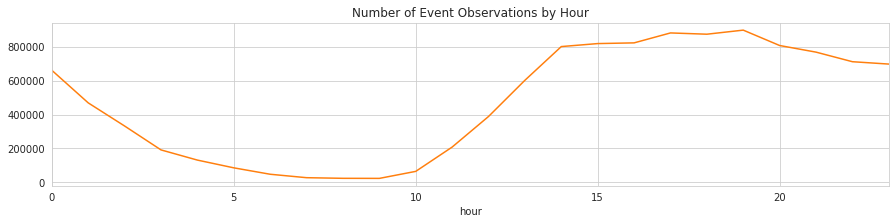

In [20]:
train.groupby('hour')['event_id'].agg('count').plot(figsize=(15, 3),
                                                    title='Number of Event Observations by Hour',
                                                    color=my_pal[1])
plt.show()

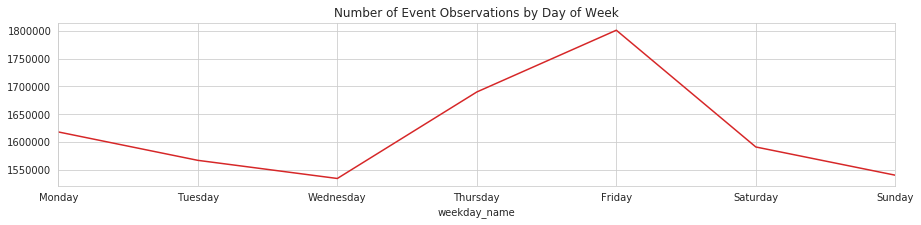

In [21]:
train.groupby('weekday_name')['event_id'].agg('count').T[['Monday', 'Tuesday', 'Wednesday',
                                                          'Thursday', 'Friday', 'Saturday', 'Sunday']].T.plot(figsize=(15, 3),
                                                          title='Number of Event Observations by Day of Week',
                                                          color=my_pal[3])
plt.show()

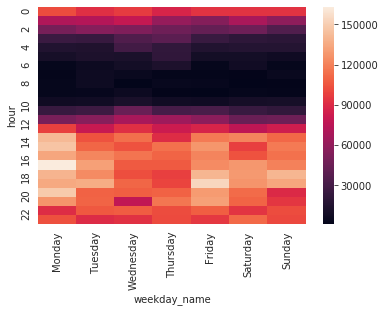

In [22]:
cross_df = train.groupby(['hour', 'weekday_name'])['event_id'].agg('count').reset_index()
cross_df = cross_df.pivot( 'hour','weekday_name', 'event_id')

sns.heatmap(cross_df, xticklabels=['Monday', 'Tuesday', 'Wednesday',
                                    'Thursday', 'Friday', 'Saturday', 'Sunday']);

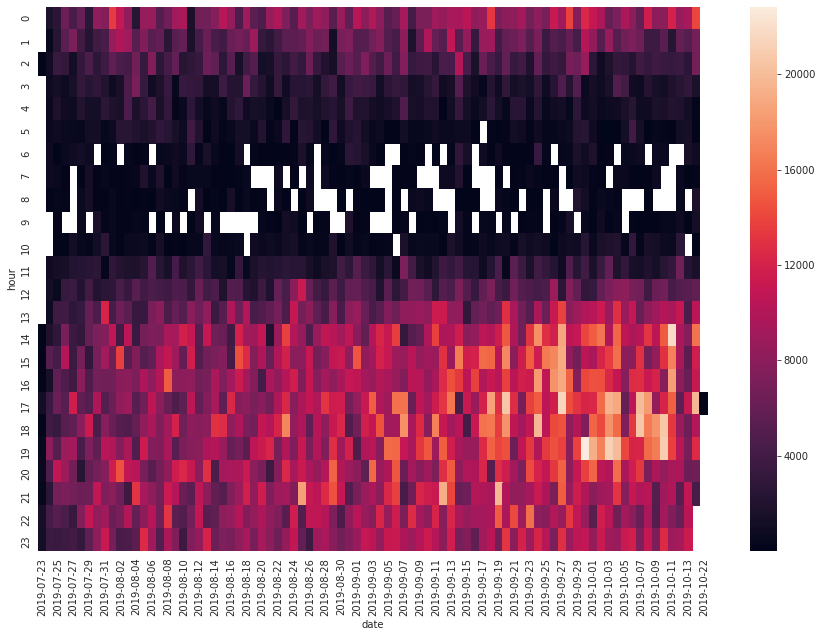

In [23]:
cross_df = train.groupby(['hour', 'date'])['event_id'].agg('count').reset_index()
cross_df = cross_df.pivot( 'hour','date', 'event_id')
fig, ax = plt.subplots(figsize=(15,10)) 
ax = sns.heatmap(cross_df);

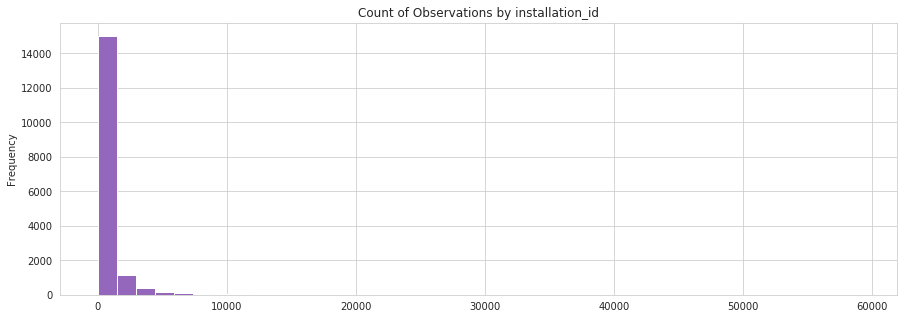

In [24]:
train.groupby('installation_id').count()['event_id'].plot(kind='hist',
                                                          bins=40,
                                                          color=my_pal[4],
                                                          figsize=(15, 5),
                                                          title='Count of Observations by installation_id')
plt.show()

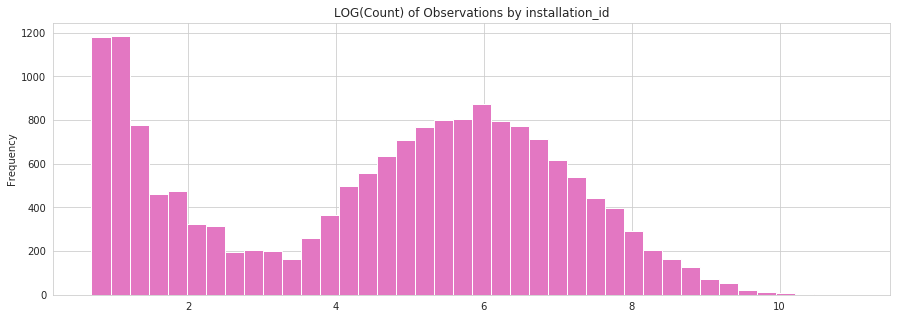

In [25]:
train.groupby('installation_id').count()['event_id'].apply(np.log1p).plot(kind='hist',
                                                                          bins=40,
                                                                          color=my_pal[6],
                                                                          figsize=(15, 5),
                                                                          title='LOG(Count) of Observations by installation_id')
plt.show();

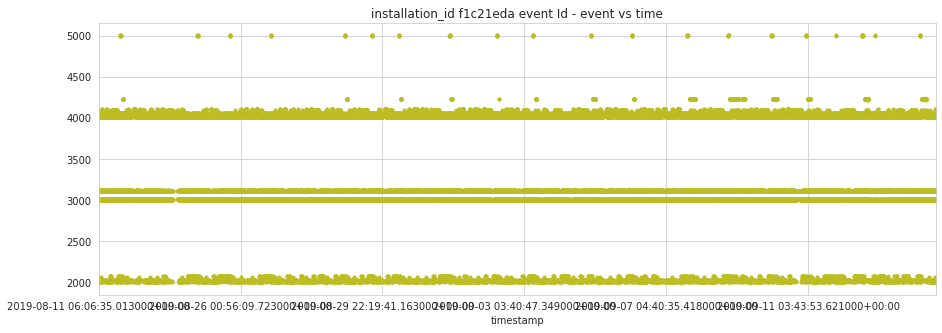

In [26]:
# botぽいインスタンスに注目する
train.query('installation_id == "f1c21eda" ').set_index('timestamp')['event_code'].plot(figsize=(15, 5),
                                                                                        title='installation_id f1c21eda event Id - event vs time',
                                                                                        style='.',
                                                                                        color=my_pal[8])
plt.show()

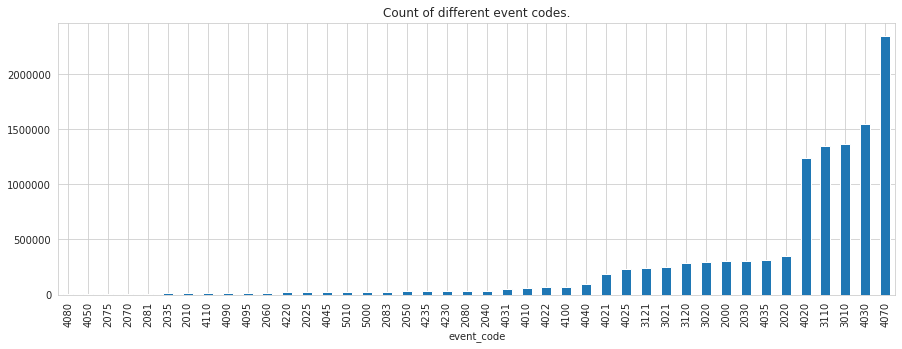

In [27]:
# event_code
train.groupby('event_code').count()['event_id'].sort_values().plot(kind='bar',
                                                                   figsize=(15, 5),
                                                                   title='Count of different event codes.')
plt.show()

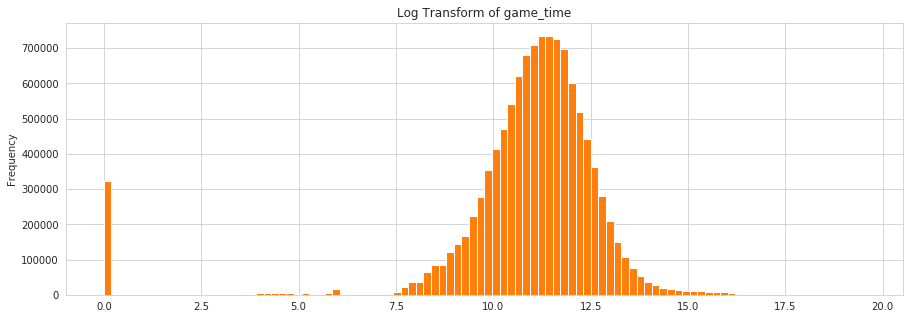

In [28]:
# game time
train['game_time'].apply(np.log1p).plot(kind='hist',
                                        figsize=(15, 5),
                                        bins=100,
                                        title='Log Transform of game_time',
                                        color=my_pal[1])
plt.show()

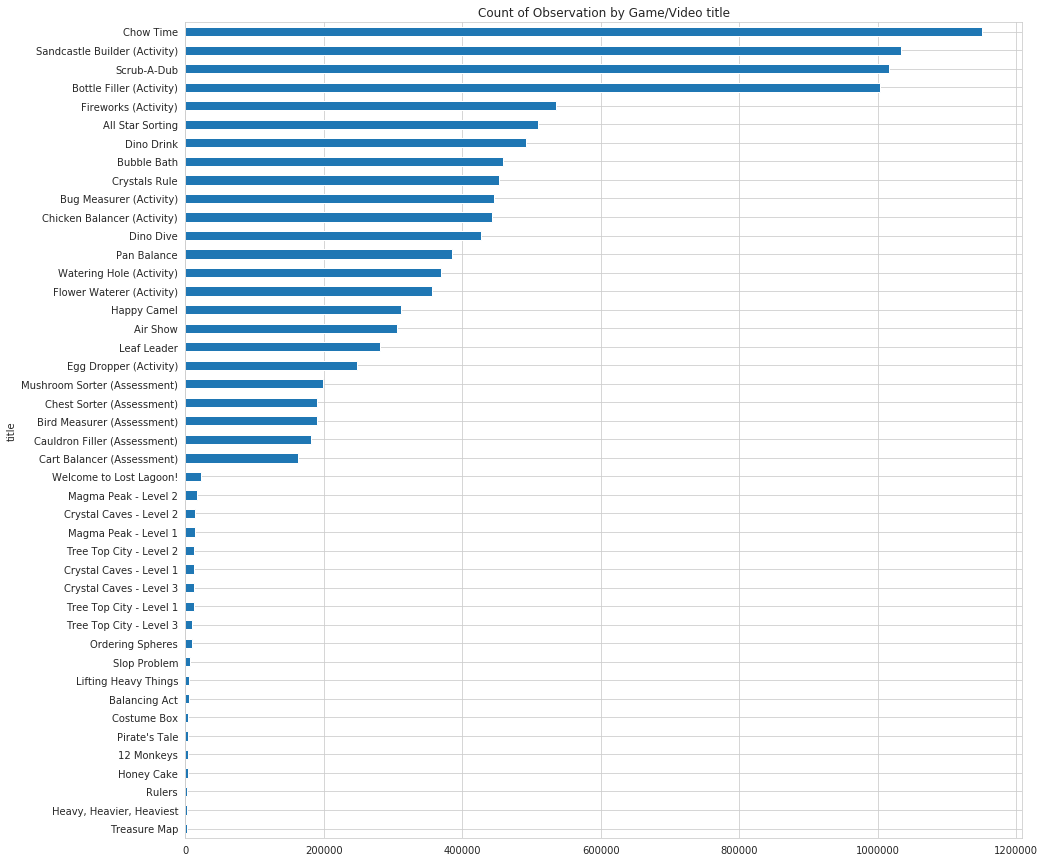

In [29]:
# Game/Video titles
train.groupby('title')['event_id'].count().sort_values().plot(kind='barh',
                                                          title='Count of Observation by Game/Video title',
                                                          figsize=(15, 15))
plt.show()

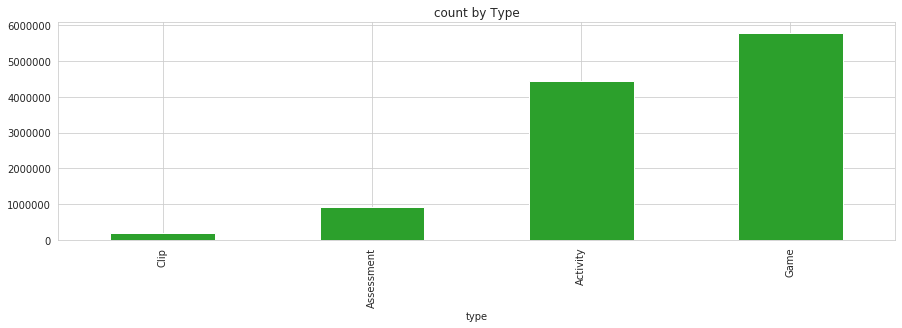

In [30]:
# Game/Video type
train.groupby('type')['event_id'].count().sort_values().plot(kind='bar',
                                                           figsize=(15,4),
                                                           title='count by Type',
                                                           color=my_pal[2])
plt.show()

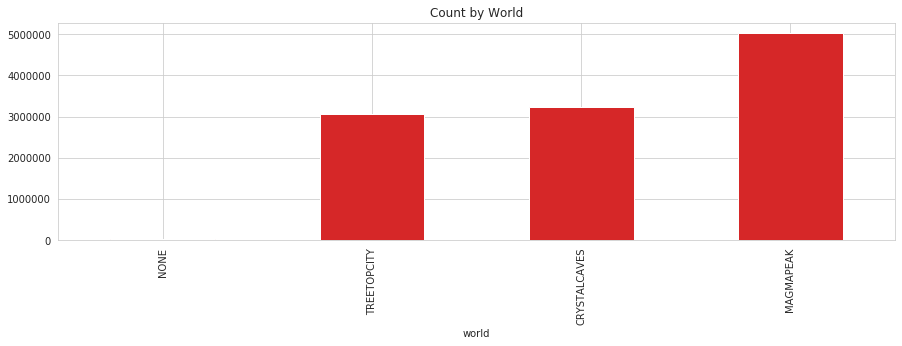

In [31]:
# World
train.groupby('world')['event_id'].count().sort_values().plot(kind='bar',
                                                            figsize=(15, 4),
                                                            title='Count by World',
                                                            color=my_pal[3])
plt.show()

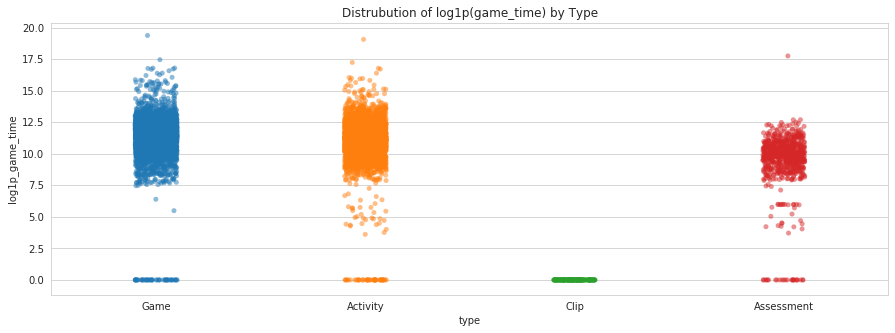

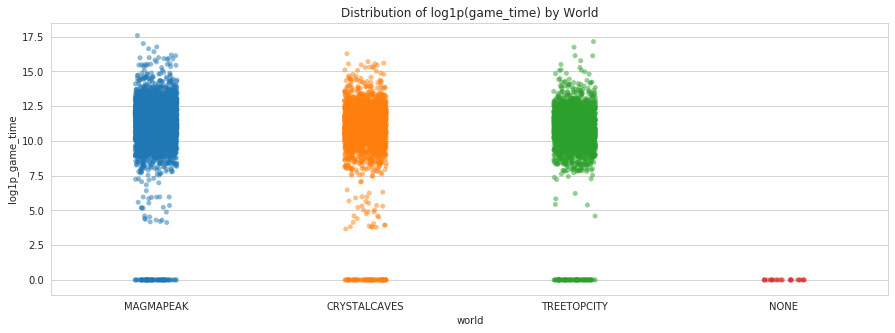

In [17]:
# log(game_time) vs game/video categories
train['log1p_game_time'] = train['game_time'].apply(np.log1p)

fig, ax = plt.subplots(figsize=(15, 5))
sns.catplot(x = "type",y = "log1p_game_time",
            data=train.sample(10000), alpha=0.5, ax=ax);
ax.set_title('Distrubution of log1p(game_time) by Type')
plt.close()
plt.show()
fig, ax = plt.subplots(figsize=(15, 5))
sns.catplot(x='world', y="log1p_game_time",
            data=train.sample(10000), alpha=0.5, ax=ax);
ax.set_title('Distribution of log1p(game_time) by World')
plt.close()
plt.show()

In [33]:
# specs.csv
specs.head()

,event_id,info,args
0,2b9272f4,The end of system-initiated feedback (Correct) event occurs when the game finishes delivering feedback to the player in response to a correct round attempt (pressing the go button with the correct...,"[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""round"",""type"":""int"",""info"":""number of the current round when the event takes place or 0 if no round""},{""n..."
1,df4fe8b6,The end of system-initiated feedback (Incorrect) event occurs when the game finishes delivering feedback to the player in response to an incorrect round attempt (pressing the go button with the in...,"[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""description"",""type"":""string"",""info"":""the text or description of the instruction""},{""name"":""identifier"",""t..."
2,3babcb9b,The end of system-initiated instruction event occurs when the game finishes delivering instructions to the player. It contains information that describes the content of the instruction including d...,"[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""round"",""type"":""int"",""info"":""number of the current round when the event takes place or 0 if no round""},{""n..."
3,7f0836bf,The end of system-initiated instruction event occurs when the game finishes delivering instructions to the player. It contains information that describes the content of the instruction including d...,"[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""round"",""type"":""int"",""info"":""number of the current round when the event takes place or 0 if no round""},{""n..."
4,ab3136ba,The end of system-initiated instruction event occurs when the game finishes delivering instructions to the player. It contains information that describes the content of the instruction including d...,"[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""round"",""type"":""int"",""info"":""number of the current round when the event takes place or 0 if no round""},{""n..."


In [34]:
specs.describe()

,event_id,info,args
count,386,386,386
unique,386,168,191
top,bb3e370b,This event occurs when the player clicks on the help button. It contains information about the state of the game that caused the player to seek help. This event is usually followed by a 3010 (syst...,"[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""round"",""type"":""int"",""info"":""number of the current round when the event takes place or 0 if no round""},{""n..."
freq,1,17,25


In [0]:
# from google.colab import files
# files.download("/content/specs.csv")

### このデータからイベントの具体的なイメージをつかみ取りたい。
+ helpを求めているとか
+ 悩んでいるとか

168個しかないなら全部見てしまえばいい。  
ただ、accuracy_groupの割合を見てみたい。

In [36]:
ss.head()

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3


In [44]:
# 提出するデータはinstallation_idはかぶっていない。
ss.installation_id.value_counts()

457d8c6f    1
25faffc4    1
4ec94f2f    1
101d16f5    1
763b2ac3    1
           ..
51bc6b81    1
b8ae746c    1
fca866bc    1
b2e61027    1
f3f98ebe    1
Name: installation_id, Length: 1000, dtype: int64

In [46]:
ss.accuracy_group.value_counts()

3    1000
Name: accuracy_group, dtype: int64

In [48]:
train.installation_id.unique().size

17001

In [75]:
train_labels.installation_id.unique().size

3614

訓練データのinstallation_idは1000件

In [47]:
test.installation_id.unique().size

1000

予測対象のinstallation_idは1000件

In [0]:
train_installation_list = train.installation_id.unique().tolist()
test_installation_list = test.installation_id.unique().tolist()

In [52]:
set(train_installation_list) & set(test_installation_list)

set()

当たり前だが、かぶるIDはない。

In [53]:
train_labels.head(3)

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3


In [54]:
train.head(3)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,event_id_as_int,game_session_as_int,date,hour,weekday_name,j_event_code,j_event_count,j_description,j_identifier,j_media_type,j_total_duration,j_game_time,j_duration,j_coordinates,j_castles_placed,j_molds,j_size,j_sand,j_filled,j_level,j_round,j_movie_id,j_round_target,j_options,j_animals,j_misses,j_shell_size,j_cloud,j_cloud_size,j_water_level,j_time_played,j_houses,j_dinosaurs,j_dinosaurs_placed,j_flower,j_flowers,j_height,j_stumps,j_source,j_correct,j_session_duration,j_exit_type,j_distance,j_target_containers,j_object,j_tutorial_step,j_toy,j_dwell_time,j_max_position,j_end_position,log1p_game_time
0,27253bdc,45bb1e1b6b50c07b,2019-09-06 17:53:46.937000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,656751580,5024642912375324795,2019-09-06,17,Friday,2000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,27253bdc,17eeb7f223665f53,2019-09-06 17:54:17.519000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,656751580,1724517957933358931,2019-09-06,17,Friday,2000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,77261ab5,0848ef14a8dc6892,2019-09-06 17:54:56.302000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0,""event_code"":2000}",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,1998985909,596989822637992082,2019-09-06,17,Friday,2000,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [55]:
train.describe(include='all')

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,event_id_as_int,game_session_as_int,date,hour,weekday_name,j_event_code,j_event_count,j_description,j_identifier,j_media_type,j_total_duration,j_game_time,j_duration,j_coordinates,j_castles_placed,j_molds,j_size,j_sand,j_filled,j_level,j_round,j_movie_id,j_round_target,j_options,j_animals,j_misses,j_shell_size,j_cloud,j_cloud_size,j_water_level,j_time_played,j_houses,j_dinosaurs,j_dinosaurs_placed,j_flower,j_flowers,j_height,j_stumps,j_source,j_correct,j_session_duration,j_exit_type,j_distance,j_target_containers,j_object,j_tutorial_step,j_toy,j_dwell_time,j_max_position,j_end_position,log1p_game_time
count,11341042,11341042,11341042,11341042,11341042,1.134104e+07,1.134104e+07,1.134104e+07,11341042,11341042,11341042,1.134104e+07,1.134104e+07,11341042,1.134104e+07,11341042,1.134104e+07,1.134104e+07,3853125,3788134,3788134,1.909720e+06,1.115737e+07,3.773430e+06,5820084,50987,1774,779985.000000,107498.000000,147021,1.016837e+06,6.799361e+06,64991,180362,92320,92320,264678.000000,151055.000000,163869,163869.000000,141396.000000,8403.000000,26619,234393,91516,138637.000000,182100,183973.000000,48369,1516311,803429,1.169600e+04,2931,37514.000000,32878.000000,227727,6925.000000,63061,9.660000e+02,1989.000000,1989.000000,1.134104e+07
unique,384,303319,10777308,10893749,17001,NaN,NaN,NaN,44,4,4,NaN,NaN,85,NaN,7,NaN,NaN,385,379,2,NaN,NaN,NaN,1295049,38100,24,NaN,NaN,2,NaN,NaN,5,15,256,182,NaN,NaN,3,NaN,NaN,NaN,231,10113,6074,NaN,11808,NaN,140,20,2,NaN,3,NaN,NaN,101,NaN,5,NaN,NaN,NaN,NaN
top,1325467d,6e6e697f2e593de1,2019-08-01 20:08:13.052000+00:00,"{""event_code"": 2000, ""event_count"": 1}",f1c21eda,NaN,NaN,NaN,Chow Time,Game,MAGMAPEAK,NaN,NaN,2019-09-27,NaN,Friday,NaN,NaN,"That's not enough food. Try putting a piece on the scale, to make that side heavier!",1438,animation,NaN,NaN,NaN,"{'x': 782, 'y': 207, 'stage_width': 1015, 'stage_height': 762}",[],"[0, 0, 0]",NaN,NaN,True,NaN,NaN,scrubadub_outro,"{'size': 3, 'type': 'Tub', 'animal': 'hog'}","[3, 4]",['sheep'],NaN,NaN,middle,NaN,NaN,NaN,"[1, 2, 3, 4, 5]","[{'name': 'none', 'size': 0}, {'name': 'none', 'size': 0}, {'name': 'none', 'size': 0}]","[{'size': 0, 'name': 'none'}, {'size': 0, 'name': 'none'}, {'size': 5, 'name': 'sonny'}]",NaN,"[0, 0, 0, 0, 0]",NaN,"[0, 0, 0]",resources,True,NaN,game_completed,NaN,NaN,chicken,NaN,ball,NaN,NaN,NaN,NaN
freq,274673,3368,11,183676,58988,NaN,NaN,NaN,1150974,5795293,5023687,NaN,NaN,200217,NaN,1801243,NaN,NaN,205082,205082,2523984,NaN,NaN,NaN,161486,9554,1101,NaN,NaN,81919,NaN,NaN,17615,14099,3115,8417,NaN,NaN,88702,NaN,NaN,NaN,3755,19373,861,NaN,21945,NaN,8813,687231,513543,NaN,2925,NaN,NaN,178085,NaN,13496,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,1.056642e+02,3.513838e+03,1.976236e+05,NaN,NaN,NaN,1.653442e+08,9.251977e+18,NaN,1.477273e+01,NaN,3.513838e+03,1.056642e+02,NaN,NaN,NaN,3.838368e+03,1.969759e+05,3.351842e+04,NaN,NaN,NaN,1.878053,1.661129,NaN,5.790331e+00,6.131968e+00,NaN,NaN,NaN,NaN,0.700036,1.980802,NaN,2.367019,2.534216,5274.535156,NaN,NaN,NaN,2.364527,NaN,184.762589,NaN,NaN,NaN,6.342488e+04,NaN,5.866210,4.158312,NaN,1.848953,NaN,1.352769e+04,0.518273,0.451960,1.085889e+01
std,NaN,NaN,NaN,NaN,NaN,1.483477e+02,6.816470e+02,1.803968e+06,NaN,NaN,NaN,1.264591e+09,5.332447e+18,NaN,6.779303e+00,NaN,6.816470e+02,1.483477e+02,NaN,NaN,NaN,3.423338e+03,1.812790e+06,7.226652e+05,NaN,NaN,NaN,1.605101,0.755354,NaN,4.269085e+00,9.737190e+00,NaN,NaN,NaN,NaN,1.578819,0.672183,NaN,0.761749,2.308925,3986.749023,NaN,NaN,NaN,1.809371,NaN,239.466812,NaN,NaN,NaN,5.816980e+05,NaN,3.003149,2.294304,NaN,1.459633,NaN,1.788341e+05,0.461625,0.457560,2.273062e+00
min,NaN,NaN,NaN,NaN,NaN,1.000000e+00,2.000000e+03,0.000000e+00,NaN,NaN,NaN,-2.142314e+09,1.351784e+13,NaN,0.000000e+00,NaN,2.000000e+03,1.000000e+00,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,0.000000,1.000000,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,0.000000,1.000000,N

trainとtestのデータをinstallation_idごとにする必要があるのではないか？  
もう1段階の前処理が必要


event_idとgame_sessionは紐付かない。

In [0]:
train_df = pd.merge(train, train_labels.drop(["installation_id","title"],axis=1), on="game_session", how="left")

In [68]:
train_df.shape

(11341042, 66)

In [69]:
train_df.head(3)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,event_id_as_int,game_session_as_int,date,hour,weekday_name,j_event_code,j_event_count,j_description,j_identifier,j_media_type,j_total_duration,j_game_time,j_duration,j_coordinates,j_castles_placed,j_molds,j_size,j_sand,j_filled,j_level,j_round,j_movie_id,j_round_target,j_options,j_animals,j_misses,j_shell_size,j_cloud,j_cloud_size,j_water_level,j_time_played,j_houses,j_dinosaurs,j_dinosaurs_placed,j_flower,j_flowers,j_height,j_stumps,j_source,j_correct,j_session_duration,j_exit_type,j_distance,j_target_containers,j_object,j_tutorial_step,j_toy,j_dwell_time,j_max_position,j_end_position,log1p_game_time,num_correct,num_incorrect,accuracy,accuracy_group
0,27253bdc,45bb1e1b6b50c07b,2019-09-06 17:53:46.937000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,656751580,5024642912375324795,2019-09-06,17,Friday,2000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,27253bdc,17eeb7f223665f53,2019-09-06 17:54:17.519000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,656751580,1724517957933358931,2019-09-06,17,Friday,2000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,77261ab5,0848ef14a8dc6892,2019-09-06 17:54:56.302000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0,""event_code"":2000}",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,1998985909,596989822637992082,2019-09-06,17,Friday,2000,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [70]:
train_df.game_session.unique().size

303319

In [71]:
train_labels.game_session.unique().size

17690

ラベルが存在しないgame_sessionが圧倒的に多い。  
試験をしない限りラベルがつかないのではないか？

In [0]:
train_df['accuracy_na_flag'] = np.where(train_df.accuracy_group.isna(), 0, 1)

In [21]:
train_df.groupby('type')['accuracy_na_flag'].agg([np.mean, 'count'])

,mean,count
type,,
Activity,0.00000,4436728
Assessment,0.93527,925345
Clip,0.00000,183676
Game,0.00000,5795293


アセスメントでなければラベルは存在しない。  

全てのinstallation_idにおいてラベルデータがあるわけではない。  
試験を受けるかどうかも予測する必要があるのではないか。

In [77]:
test[test['type']=="Assessment"].installation_id.unique().size

1000

テストデータは、全員アセスメントは受けているらしい。  
アセスメントを受けていない人のデータは除外する。  
どのみちラベルもないし。

In [0]:
# assesmentを一度も受けていないinstallation_idのデータを除外する
assessed_installation_id_list = train_df[train_df['type']=="Assessment"].installation_id.unique().tolist()
train_df = train_df[ train_df.installation_id.isin(assessed_installation_id_list)].reset_index(drop=True)

In [31]:
train_df.shape

(8294138, 18)

In [32]:
train_df.query(' installation_id == "0006a69f" ').groupby('title')["accuracy_na_flag"].agg([np.mean, 'count']) #["accuracy_group"].value_counts()

,mean,count
title,,
12 Monkeys,0.000000,2
Air Show,0.000000,295
All Star Sorting,0.000000,203
Bird Measurer (Assessment),1.000000,119
Bottle Filler (Activity),0.000000,293
Bubble Bath,0.000000,248
Bug Measurer (Activity),0.000000,319
Costume Box,0.000000,3
Crystals Rule,0.000000,212


一人のユーザーが何回もアセスメントを受けることもある。  
ゲームに対しての予測を行うべきだが、訓練データには一人のユーザーに対して復数のアセスメントがある。  
あるユーザーのあるタイトルに対してのアセスメントの予測をする必要があると思われる。  
テストデータには復数のタイトルがあるのだろうか？

In [92]:
test[test.title.str.contains('Assessment')].groupby(["installation_id", "title"])["event_id"].agg(['count'])

count
installation_id title                              
00abaee7        Cart Balancer (Assessment)       26
                Cauldron Filler (Assessment)      1
01242218        Bird Measurer (Assessment)       61
                Cart Balancer (Assessment)       14
                Cauldron Filler (Assessment)     36
...                                             ...
ffc73fb2        Mushroom Sorter (Assessment)     46
ffe00ca8        Cart Balancer (Assessment)        1
                Cauldron Filler (Assessment)    109
ffe774cc        Bird Measurer (Assessment)        1
                Mushroom Sorter (Assessment)     41

[2046 rows x 1 columns]

復数のアセスメントを受けているケースがある。  
タイトルごとに予測をして加重平均を取るなどを考えると良い？

In [93]:
train.title.value_counts()

Chow Time                        1150974
Sandcastle Builder (Activity)    1034332
Scrub-A-Dub                      1016837
Bottle Filler (Activity)         1004068
Fireworks (Activity)              535030
All Star Sorting                  509344
Dino Drink                        492916
Bubble Bath                       458972
Crystals Rule                     453852
Bug Measurer (Activity)           446430
Chicken Balancer (Activity)       443156
Dino Dive                         427655
Pan Balance                       384857
Watering Hole (Activity)          369270
Flower Waterer (Activity)         356034
Happy Camel                       311543
Air Show                          306239
Leaf Leader                       282104
Egg Dropper (Activity)            248408
Mushroom Sorter (Assessment)      199595
Chest Sorter (Assessment)         190318
Bird Measurer (Assessment)        190164
Cauldron Filler (Assessment)      181925
Cart Balancer (Assessment)        163343
Welcome to Lost 

一つのgame_sessionで復数のアセスメントはない？

In [100]:
train_df[train_df.title.str.contains('Assessment')].groupby(['game_session', 'title'])['accuracy_na_flag'].agg([np.mean, np.sum])#.sort_values(by=["sum"], ascending=False)

,,mean,sum
game_session,title,,
00097cda27afb726,Mushroom Sorter (Assessment),1,36
000f68cff32664ef,Chest Sorter (Assessment),1,201
0014403daadf67aa,Bird Measurer (Assessment),1,79
0014daa1d3e26eb2,Mushroom Sorter (Assessment),1,72
0018a3df8beb755e,Cart Balancer (Assessment),0,0
...,...,...,...
fff20fa828fb1a94,Cart Balancer (Assessment),1,13
fff441b089d7b1ef,Cauldron Filler (Assessment),1,26
fff53215178ede64,Bird Measurer (Assessment),1,33


In [101]:
train_df[train_df.title.str.contains('Assessment')].game_session.unique().size

21239

アセスメント受けているけどラベルのデータが存在しないケースがあるが、一つのgame_sessionに対して1つのアセスメントになっている。  
game_sessionごとのデータセットを作っていけば良さそう。

In [106]:
train_df

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,event_id_as_int,game_session_as_int,date,hour,weekday_name,j_event_code,j_event_count,j_description,j_identifier,j_media_type,j_total_duration,j_game_time,j_duration,j_coordinates,j_castles_placed,j_molds,j_size,j_sand,j_filled,j_level,j_round,j_movie_id,j_round_target,j_options,j_animals,j_misses,j_shell_size,j_cloud,j_cloud_size,j_water_level,j_time_played,j_houses,j_dinosaurs,j_dinosaurs_placed,j_flower,j_flowers,j_height,j_stumps,j_source,j_correct,j_session_duration,j_exit_type,j_distance,j_target_containers,j_object,j_tutorial_step,j_toy,j_dwell_time,j_max_position,j_end_position,log1p_game_time,num_correct,num_incorrect,accuracy,accuracy_group,accuracy_na_flag
0,27253bdc,34ba1a28d02ba8ba,2019-08-06 04:57:18.904000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,656751580,3799377998233970874,2019-08-06,4,Tuesday,2000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0
1,27253bdc,4b57c9a59474a1b9,2019-08-06 04:57:45.301000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,656751580,5429029588815880633,2019-08-06,4,Tuesday,2000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0
2,77261ab5,2b9d5af79bcdb79f,2019-08-06 04:58:14.538000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0,""event_code"":2000}",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,1998985909,3142768134491846559,2019-08-06,4,Tuesday,2000,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0
3,b2dba42b,2b9d5af79bcdb79f,2019-08-06 04:58:14.615000+00:00,"{""description"":""Let's build a sandcastle! First, fill up your mold with sand! You can use the shovel here. The mold gives the sand its shape!"",""identifier"":""Dot_LetsSandcastle,Dot_FillMold,Dot_Mol...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK,-1294228437,3142768134491846559,2019-08-06,4,Tuesday,3010,2,"Let's build a sandcastle! First, fill up your mold with sand! You can use the shovel here. The mold gives the sand its shape!","Dot_LetsSandcastle,Dot_FillMold,Dot_MoldShape",audio,6758.0,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.401197,NaN,NaN,NaN,NaN,0
4,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:16.680000+00:00,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":1015,""stage_height"":762},""event_count"":3,""game_time"":2137,""event_code"":4070}",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK,321209981,3142768134491846559,2019-08-06,4,Tuesday,4070,3,NaN,NaN,NaN,NaN,2137.0,NaN,"{'x': 273, 'y': 650, 'stage_width': 1015, 'stage_height': 762}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.667626,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8294133,28520915,5448d652309a6324,2019-09-22 02:07:27.562000+00:00,"{""misses"":1,""prompt"":""holds least"",""mode"":""selecting"",""round_number"":2,""duration"":7067,""event_count"":58,""game_time"":67094,""event_code"":2030}",ffeb0b1b,58,2030,67094,Cauldron Filler (Assessment),

In [0]:
# train_df_pivot = pd.pivot_table(data=train_df ,
#                                 fill_value=0, 
#                                 index="game_session",
#                                 columns="title",
#                                 aggfunc = {  'game_time' : np.sum })

# column_name = ["game_session"]
# column_name.extend(train_df_pivot.columns.levels[1].tolist())

# train_df_pivot = train_df_pivot.reset_index()
# train_df_pivot.columns = column_name

In [0]:
# train_df_pivot = pd.merge(train_df_pivot, train_labels, on="game_session", how="left")

In [0]:
# train_df_pivot[~train_df_pivot.accuracy_group.isna()]

他のゲームもやっていたはずだが、game_sessionでデータを作ってしまうと、データの中に含まれなくなる。  
installation_id単位でそのゲームをやった段階で蓄積されているログを集計するようにする。

In [0]:
# instalattion_idごとにtimestamp順に並び替える。
# assesmentのあったレコードがあるたびに、それまでの蓄積データを集計するようにする。
# それまでの累積をpivotする関数を使う。そのあと、assessmentのgame_sessionに絞ればいい。
# installation_idごとに累積？

In [0]:
train_df = train_df.sort_values( by=["installation_id", "timestamp"],ascending=True).reset_index(drop=True)

In [42]:
train_df.groupby(['installation_id','title', 'game_session'])["timestamp"].count()

installation_id  title                    game_session    
96979008         Air Show                 61857794a2c0f13b    436
                                          6d53ad4c891b6111    217
                                          76ccaa4526e00345    600
                                          fc6256687da1c1fc     68
                 All Star Sorting         a57253df4c4bf5b4    187
                                                             ... 
ffeb0b1b         Tree Top City - Level 1  a5e1a8d767ebf28c      1
                                          ead68f52fcce38ff      1
                 Welcome to Lost Lagoon!  1e44ae9ce7451c52      1
                                          216dd848ba814851      1
                                          63d90e37523bd3cc      1
Name: timestamp, Length: 195447, dtype: int64

In [0]:
train_df["date"] = pd.to_datetime(train_df.timestamp)
train_df["date"] = train_df["date"].dt.date

In [48]:
train_df.timestamp.min()

'2019-07-23 14:38:25.256000+00:00'

In [49]:
train_df.timestamp.max()

'2019-10-22 17:41:45.983000+00:00'

In [0]:
date_df = pd.DataFrame(pd.date_range('2019-07-23', periods=92, freq='D').date, columns=['date'])
installation_id_df = pd.DataFrame(train_df['installation_id'].unique(), columns=['installation_id'])
title_df = pd.DataFrame(train_df['title'].unique(), columns=['title'])

date_df['key'] = 0
installation_id_df['key'] = 0
title_df['key'] = 0

tmp_df = date_df.merge(installation_id_df, on='key')
tmp_df = tmp_df.merge(title_df, on='key').drop('key', axis=1)

In [85]:
tmp_df 

,date,installation_id,title
0,2019-07-23,96979008,Bubble Bath
1,2019-07-23,96979008,Chicken Balancer (Activity)
2,2019-07-23,96979008,Lifting Heavy Things
3,2019-07-23,96979008,Crystal Caves - Level 2
4,2019-07-23,96979008,Cart Balancer (Assessment)
...,...,...,...
17175659,2019-10-22,ffeb0b1b,Ordering Spheres
17175660,2019-10-22,ffeb0b1b,Treasure Map
17175661,2019-10-22,ffeb0b1b,Slop Problem
17175662,2019-10-22,ffeb0b1b,Costume Box


In [86]:
pd.DataFrame(train_df.groupby(['installation_id', 'date', 'title'])['event_id'].count()).reset_index()

,installation_id,date,title,event_id
0,96979008,2019-08-09,Bottle Filler (Activity),219
1,96979008,2019-08-09,Bubble Bath,148
2,96979008,2019-08-09,Cart Balancer (Assessment),69
3,96979008,2019-08-09,Chest Sorter (Assessment),61
4,96979008,2019-08-09,Chicken Balancer (Activity),170
...,...,...,...,...
149074,ffeb0b1b,2019-09-22,Cauldron Filler (Assessment),61
149075,ffeb0b1b,2019-09-22,Magma Peak - Level 1,1
149076,ffeb0b1b,2019-09-22,Mushroom Sorter (Assessment),97
149077,ffeb0b1b,2019-09-22,Ordering Spheres,3


In [0]:
sum_df = pd.DataFrame(train_df.groupby(['installation_id', 'date', 'title'])['event_id'].count()).reset_index()
sum_df = tmp_df.merge(sum_df, on=['date', 'installation_id', 'title'], how='left')

sum_df = sum_df.fillna(0)
sum_df = sum_df.rename(columns={ "event_id":"count_record"})

sum_df['installation_id_title_cumsum'] = sum_df.groupby(['installation_id', 'title']).cumsum()['count_record']

In [95]:
sum_df

,date,installation_id,title,count_record,installation_id_title_cumsum
0,2019-07-23,96979008,Bubble Bath,0.0,0.0
1,2019-07-23,96979008,Chicken Balancer (Activity),0.0,0.0
2,2019-07-23,96979008,Lifting Heavy Things,0.0,0.0
3,2019-07-23,96979008,Crystal Caves - Level 2,0.0,0.0
4,2019-07-23,96979008,Cart Balancer (Assessment),0.0,0.0
...,...,...,...,...,...
17175659,2019-10-22,ffeb0b1b,Ordering Spheres,0.0,13.0
17175660,2019-10-22,ffeb0b1b,Treasure Map,0.0,0.0
17175661,2019-10-22,ffeb0b1b,Slop Problem,0.0,0.0
17175662,2019-10-22,ffeb0b1b,Costume Box,0.0,0.0


In [0]:
train_df_pivot = pd.pivot_table(data=sum_df,
                                fill_value=0, 
                                index=['installation_id', 'date'],
                                columns="title",
                                aggfunc = {  'installation_id_title_cumsum' : np.sum })

column_name = ["installation_id", "date"]
column_name.extend(train_df_pivot.columns.levels[1].tolist())
train_df_pivot = train_df_pivot.reset_index()
train_df_pivot.columns = column_name

installation_idごとのアセスメントの発生した日を抽出

In [0]:
assessment_date_list = pd.DataFrame(train_df[train_df['type']=='Assessment'].groupby(['installation_id', 'date', 'game_session'])['accuracy_na_flag'].sum()).reset_index()
assessment_date_list = assessment_date_list.query(' accuracy_na_flag > 0  ').reset_index(drop=True)

In [0]:
train_df_pivot = assessment_date_list.merge(train_df_pivot, on=['installation_id', 'date'], how="left")

In [0]:
train_df_pivot = train_df_pivot.merge(train_labels.drop(columns=['installation_id'], axis=1), on="game_session", how="left")
train_df_pivot = train_df_pivot[~train_df_pivot.duplicated(subset=["installation_id", "title"], keep='last')].reset_index(drop=True)

In [34]:
train_df_pivot.groupby('title')['accuracy'].agg([np.mean, 'count'])

,mean,count
title,,
Bird Measurer (Assessment),0.417888,1587
Cart Balancer (Assessment),0.744200,2100
Cauldron Filler (Assessment),0.734015,1985
Chest Sorter (Assessment),0.238966,1724
Mushroom Sorter (Assessment),0.724751,1990


+ Chest Sorter
+ Bird Measure  
は難しいらしい。

In [0]:
train_df[~train_df.accuracy_group.isna()].groupby('event_id')['accuracy'].agg([np.mean, 'count'])

関係してそうなので、イベントのピボットも作成した方がいい。

In [0]:
date_df = pd.DataFrame(pd.date_range('2019-07-23', periods=92, freq='D').date, columns=['date'])
installation_id_df = pd.DataFrame(train_df['installation_id'].unique(), columns=['installation_id'])
sum_df = pd.DataFrame(train_df['event_id_unique'].unique(), columns=['event_id_unique'])

In [0]:
date_df['key'] = 0
installation_id_df['key'] = 0
sum_df['key'] = 0

tmp_df = date_df.merge(installation_id_df, on='key')
tmp_df = tmp_df.merge(sum_df, on='key').drop('key', axis=1)

In [37]:
tmp_df.shape

(62832504, 3)

In [0]:
sum_df = pd.DataFrame(train_df.groupby(['installation_id', 'date', 'event_id_unique'])['game_session'].count()).reset_index()
sum_df = tmp_df.merge(sum_df, on=['date', 'installation_id', 'event_id_unique'], how='left')

sum_df = sum_df.fillna(0)
sum_df = sum_df.rename(columns={ "game_session":"count_record"})

sum_df['installation_id_event_id_unique_cumsum'] = sum_df.groupby(['installation_id', 'event_id_unique']).cumsum()['count_record']

In [0]:
event_df_pivot = pd.pivot_table(data=sum_df,
                                fill_value=0, 
                                index=['installation_id', 'date'],
                                columns="event_id_unique",
                                aggfunc = {  'installation_id_event_id_unique_cumsum' : np.sum })

column_name = ["installation_id", "date"]
column_name.extend(event_df_pivot.columns.levels[1].tolist())
event_df_pivot = event_df_pivot.reset_index()
event_df_pivot.columns = column_name

In [0]:
event_df_pivot = assessment_date_list.merge(event_df_pivot, on=['installation_id', 'date'], how="left")


In [0]:
event_df_pivot = event_df_pivot.merge(train_labels.drop(columns=['installation_id'], axis=1), on="game_session", how="left")
event_df_pivot = event_df_pivot[~event_df_pivot.duplicated(subset=["installation_id", "title"], keep='last')].reset_index(drop=True)

In [0]:
corr_df = pd.DataFrame(event_df_pivot.corr())

In [0]:
corr_df[corr_df.index == "accuracy"].transpose().sort_values(by="accuracy")

CVの際に訓練データとvalidationデータに同じinstallation_idが含まれないようにする。

In [0]:
from sklearn.model_selection import GroupKFold

# groupsとして、installation_idをおく。
# groups = np.array([0, 0, 2, 2])
# group_kfold = GroupKFold(n_splits=2)
# group_kfold.get_n_splits(X, y, groups)

In [0]:
# eventとタイトルのデータをつなぐ
train_df_pivot = train_df_pivot.merge(event_df_pivot.drop(columns=['accuracy_na_flag', 'title','num_correct',
                                                                      'num_incorrect','accuracy','accuracy_group'], axis=1), on=['installation_id','date','game_session'], how="left")

In [0]:
train_df_pivot.iloc[:,53:].columns.tolist()

In [0]:
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import cohen_kappa_score

In [0]:
dataset_ml = train_df_pivot[["installation_id", "game_session","12 Monkeys","Air Show","All Star Sorting","Balancing Act","Bird Measurer (Assessment)","Bottle Filler (Activity)","Bubble Bath","Bug Measurer (Activity)","Cart Balancer (Assessment)","Cauldron Filler (Assessment)","Chest Sorter (Assessment)","Chicken Balancer (Activity)","Chow Time","Costume Box","Crystal Caves - Level 1","Crystal Caves - Level 2","Crystal Caves - Level 3","Crystals Rule","Dino Dive","Dino Drink","Egg Dropper (Activity)","Fireworks (Activity)","Flower Waterer (Activity)","Happy Camel","Heavy, Heavier, Heaviest","Honey Cake","Leaf Leader","Lifting Heavy Things","Magma Peak - Level 1","Magma Peak - Level 2","Mushroom Sorter (Assessment)","Ordering Spheres","Pan Balance","Pirate's Tale","Rulers","Sandcastle Builder (Activity)","Scrub-A-Dub","Slop Problem","Treasure Map","Tree Top City - Level 1","Tree Top City - Level 2","Tree Top City - Level 3","Watering Hole (Activity)","Welcome to Lost Lagoon!"
]]

train_df_pivot['title'] = pd.Categorical(train_df_pivot['title'])
title_dummy = pd.get_dummies(train_df_pivot['title'], drop_first=True)

column_name = title_dummy.columns.tolist()
column_name = [ "dummy_"+str(i) for i in column_name ]
title_dummy.columns = column_name

event_data = train_df_pivot[['022b4259','02a42007','070a5291','08fd73f3','0d18d96c','0db6d71d','119b5b02','1325467d','1340b8d7','14de4c5d','155f62a4','15ba1109','17113b36','17ca3959','1996c610','1af8be29','1cc7cfca','1cf54632','1f19558b','25fa8af4','262136f4','27253bdc','28520915','28a4eb9a','28ed704e','28f975ea','2a444e03','2b9272f4','2c4e6db0','2dc29e21','2fb91ec1','30614231','3323d7e9','33505eae','363c86c9','363d3849','37c53127','37db1c2f','37ee8496','38074c54','392e14df','3babcb9b','3bb91dda','3d0b9317','3d63345e','3d8c61b0','3ddc79c3','3dfd4aa4','3edf6747','461eace6','46cd75b4','47026d5f','499edb7c','4a4c3d21','4b5efe37','4c2ec19f','4e5fc6f5','4ef8cdd3','51102b85','532a2afb','5348fd84','53c6e11a','562cec5f','56817e2b','56bcd38d','598f4598','5c2f29ca','5c3d2b2f','5d042115','5e109ec3','5e812b27','5f0eb72c','6088b756','63f13dd7','65a38bf7','6bf9e3e1','6c930e6e','709b1251','71e712d8','736f9581','74e5f8a7','795e4a37','7961e599','7cf1bc53','7d093bf9','7d5c30a2','7f0836bf','804ee27f','83c6c409','84538528','857f21c0','85de926c','86ba578b','86c924c4','8af75982','8fee50e2','90efca10','91561152','92687c59','93b353f2','93edfe2e','99abe2bb','9ce586dd','9d4e7b25','9e4c8c7b','9ee1c98c','a1192f43','a2df0760','a5e9da97','a6d66e51','a76029ee','a7640a16','a8cc6fec','a8efe47b','ad148f58','b012cd7f','b120f2ac','b1d5101d','b74258a0','b7530680','b7dc8128','bb3e370b','bc8f2793','bcceccc6','c0415e5c','c189aaf2','c1cac9a2','c277e121','c54cf6c5','c58186bf','c6971acf','c7128948','ca11f653','cdd22e43','cfbd47c8','d02b7a8e','d06f75b5','d122731b','d185d3ea','d2659ab4','d2e9262e','d38c2fd7','d3f1e122','d45ed6a1','d88e8f25','daac11b0','db02c830','dcaede90','dcb55a27','de26c3a6','df4fe8b6','e080a381','e694a35b','e7561dd2','e9c52111','ec138c1c','ecc36b7f','ecc6157f','f50fc6c1','fbaf3456','fcfdffb6']]


dataset_ml = pd.concat([dataset_ml,
                          event_data
                          # title_dummy
                        ],axis=1)

dataset_label = train_df_pivot['accuracy_group']

In [164]:
dataset_ml.describe()

,12 Monkeys,Air Show,All Star Sorting,Balancing Act,Bird Measurer (Assessment),Bottle Filler (Activity),Bubble Bath,Bug Measurer (Activity),Cart Balancer (Assessment),Cauldron Filler (Assessment),Chest Sorter (Assessment),Chicken Balancer (Activity),Chow Time,Costume Box,Crystal Caves - Level 1,Crystal Caves - Level 2,Crystal Caves - Level 3,Crystals Rule,Dino Dive,Dino Drink,Egg Dropper (Activity),Fireworks (Activity),Flower Waterer (Activity),Happy Camel,"Heavy, Heavier, Heaviest",Honey Cake,Leaf Leader,Lifting Heavy Things,Magma Peak - Level 1,Magma Peak - Level 2,Mushroom Sorter (Assessment),Ordering Spheres,Pan Balance,Pirate's Tale,Rulers,Sandcastle Builder (Activity),Scrub-A-Dub,Slop Problem,Treasure Map,Tree Top City - Level 1,Tree Top City - Level 2,Tree Top City - Level 3,Watering Hole (Activity),Welcome to Lost Lagoon!,022b4259,02a42007,0413e89d,070a5291,08fd73f3,0d18d96c,...,a7640a16,a8cc6fec,a8efe47b,ad148f58,b012cd7f,b120f2ac,b1d5101d,b74258a0,b7530680,b7dc8128,bb3e370b,bc8f2793,bcceccc6,c0415e5c,c189aaf2,c1cac9a2,c277e121,c54cf6c5,c58186bf,c6971acf,c7128948,ca11f653,cdd22e43,cfbd47c8,d02b7a8e,d06f75b5,d122731b,d185d3ea,d2659ab4,d2e9262e,d38c2fd7,d3f1e122,d45ed6a1,d88e8f25,daac11b0,db02c830,dcaede90,dcb55a27,de26c3a6,df4fe8b6,e080a381,e694a35b,e7561dd2,e9c52111,ec138c1c,ecc36b7f,ecc6157f,f50fc6c1,fbaf3456,fcfdffb6
count,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.00000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,...,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000
mean,0.967824,83.621671,84.857128,1.052418,73.299169,197.035585,100.488813,114.885255,53.999254,62.088216,70.315896,94.953548,161.223418,0.916152,1.392606,2.24462,2.153846,122.959301,97.371191,95.936714,66.164926,114.426699,86.720009,82.608353,0.815150,0.860430,71.096101,1.045919,1.400810,2.475709,68.132964,1.430322,108.258044,1.001811,0.796399,152.410079,199.833902,1.146921,0.756126,1.379395,2.089388,1.796399,69.973684,1.944279,6.651076,23.593757,32.133816,0.934797,22.718730,0.076923,...,141.887385,4.375772,17.980077,7.233113,14.204880,1.301087,1.704453,1.213083,15.757724,1.064884,50.590880,2.566908,112.644577,8.839655,5.009056,1.903154,1.301193,1.775197,6.003622,1.934157,1.375879,2.857554,12.021415,28.534200,3.004581,1.652781,2.366610,8.982634,0.497656,8.373322,0.667697,12.616557,1.284786,20.842531,2.793096,1.590667,6.853292,0.706904,10.594822,20.548583,0.592691,21.818773,7.434051,14.336032,1.890156,1.235137,0.154805,15.158321,7.273279,13.503196
std,2.660797,193.326574,166.017699,2.047653,122.639368,358.930681,246.946056,212.937954,85.020317,124.459591,108.165198,195.214515,307.101173,2.459843,1.835489,3.63556,3.917120,294.009394,207.267718,189.909410,109.046783,212.497440,178.578828,164.098329,2.100823,1.698888,136.124305,2.262412,1.957137,4.750762,121.176803,4.170538,236.307162,2.760150,1.913358,292.165624,487.113974,3.097224,2.612310,1.949768,3.923428,3.583124,144.710367,3.751865,12.625318,43.359537,66.548790,1.6

In [0]:
# 訓練データとテストデータを分ける
data_train, data_test, label_train, label_test = train_test_split(dataset_ml, dataset_label,
                                                                          train_size=0.8, 
                                                                          test_size=0.2, 
                                                                          random_state=123)

In [39]:
label_train.values

array([3, 0, 0, ..., 0, 1, 2])

In [0]:
from sklearn.preprocessing import StandardScaler

# IDたちをさける
data_train_std = data_train.drop(columns=["installation_id", "game_session"],axis=1)
data_test_std = data_test.drop(columns=["installation_id", "game_session"],axis=1)

# 正規化を行う
sc = StandardScaler(with_mean=False)
sc.fit(data_train_std.astype("float"))
data_train_std = sc.transform(data_train_std.astype("float"))
data_test_std = sc.transform(data_test_std.astype("float"))

In [41]:
classifier = XGBClassifier(
                        learning_rate =0.05, # 0.2
                        n_estimators=139, # 239
                        max_depth=5, #5
                        min_child_weight=5, #5
                        gamma=0.1, # 0.1
                        subsample=0.7, # 0.7
                        colsample_bytree=0.9 , # 0.9
                        objective= 'multi:softmax',
                        num_class='4',
                        nthread=4,
                        scale_pos_weight=0.5, # 0.5
                        seed=27
                        )
classifier 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=None, n_estimators=139, n_jobs=1,
              nthread=4, num_class='4', objective='multi:softmax',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=0.5,
              seed=27, silent=None, subsample=0.7, verbosity=1)

In [0]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10,random_state=123)

In [0]:
def inference_validation(test_X,test_y,model,n_class=4,folds=10):
    accuracy_list = []
    kappa_list = []

    from sklearn.model_selection import StratifiedKFold
    print(test_X.shape,test_y.shape)
    pred = np.zeros(test_X.shape[0])
    
    cv = StratifiedKFold(n_splits=folds, random_state=123)
    
    for train, test in cv.split(test_X, test_y):
        model = model
        model.fit(test_X[train], test_y[train])
    
        pred_class = model.predict(test_X[test])
        act_class = test_y[test]
        accuracy = np.sum([pred_class == act_class])*1.0/len(test_X[test])
        kappa = cohen_kappa_score(pred_class,act_class,weights='quadratic')

        accuracy_list.append(accuracy)
        kappa_list.append(kappa)
        print("accuracy:",accuracy, "\nkappa:",kappa)

    mean_accuracy = np.mean(accuracy_list, axis=0)
    mean_kappa = np.mean(kappa_list, axis=0)

    return mean_accuracy,mean_kappa

In [63]:
inference_validation(data_train_std, label_train.values,classifier,n_class=4,folds=10)

(7508, 205) (7508,)
accuracy: 0.62982689747004 
kappa: 0.46090791434080114
accuracy: 0.6284953395472703 
kappa: 0.4539006006475579
accuracy: 0.611185086551265 
kappa: 0.46289389958591576
accuracy: 0.6218375499334221 
kappa: 0.450698029125869
accuracy: 0.6498002663115846 
kappa: 0.5234058989914361
accuracy: 0.6364846870838882 
kappa: 0.46832475703487775
accuracy: 0.6045272969374168 
kappa: 0.4438640409254646
accuracy: 0.6524633821571239 
kappa: 0.5154121651620541
accuracy: 0.6173333333333333 
kappa: 0.42570212546596253
accuracy: 0.6386666666666667 
kappa: 0.4903080622357229


(0.6290620505992011, 0.46954174935156623)

In [43]:
classifier.fit(data_train_std, label_train.values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=None, n_estimators=139, n_jobs=1,
              nthread=4, num_class='4', objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=0.5,
              seed=27, silent=None, subsample=0.7, verbosity=1)

In [0]:
pred_class = classifier.predict(data_test_std)

In [0]:
act_class = label_test.values
accuracy = np.sum([pred_class == act_class])*1.0/len(data_test_std)
kappa = cohen_kappa_score(pred_class,act_class,weights='quadratic')

In [67]:
kappa

0.4537830547542583

## 予測用のデータセットを作成

In [0]:
test_df = test.sort_values( by=["installation_id", "timestamp"],ascending=True).reset_index(drop=True)

In [0]:
test_df["date"] = pd.to_datetime(test_df.timestamp)
test_df["date"] = test_df["date"].dt.date

In [48]:
test_df.timestamp.min()

'2019-07-24T00:04:25.361Z'

In [71]:
test_df.timestamp.max()

'2019-10-14T21:00:34.858Z'

In [0]:
date_df = pd.DataFrame(pd.date_range('2019-07-24', periods=83, freq='D').date, columns=['date'])

In [0]:
installation_id_df = pd.DataFrame(test_df['installation_id'].unique(), columns=['installation_id'])
title_df = pd.DataFrame(test_df['title'].unique(), columns=['title'])

In [0]:
date_df['key'] = 0
installation_id_df['key'] = 0
title_df['key'] = 0

tmp_df = date_df.merge(installation_id_df, on='key')
tmp_df = tmp_df.merge(title_df, on='key').drop('key', axis=1)

In [0]:
sum_df = pd.DataFrame(test_df.groupby(['installation_id', 'date', 'title'])['event_id'].count()).reset_index()
sum_df = tmp_df.merge(sum_df, on=['date', 'installation_id', 'title'], how='left')

sum_df = sum_df.fillna(0)
sum_df = sum_df.rename(columns={ "event_id":"count_record"})

sum_df['installation_id_title_cumsum'] = sum_df.groupby(['installation_id', 'title']).cumsum()['count_record']


In [0]:
test_df_pivot = pd.pivot_table(data=sum_df,
                                fill_value=0, 
                                index=['installation_id', 'date'],
                                columns="title",
                                aggfunc = {  'installation_id_title_cumsum' : np.sum })

column_name = ["installation_id", "date"]
column_name.extend(test_df_pivot.columns.levels[1].tolist())
test_df_pivot = test_df_pivot.reset_index()
test_df_pivot.columns = column_name

In [0]:
assessment_date_list = pd.DataFrame(test_df[test_df['type']=='Assessment'].groupby(['installation_id', 'date', 'game_session'])['title'].count()).reset_index()

In [0]:
test_df_pivot = assessment_date_list.merge(test_df_pivot, on=['installation_id', 'date'], how="left")

In [79]:
test_df_pivot

,installation_id,date,game_session,title,12 Monkeys,Air Show,All Star Sorting,Balancing Act,Bird Measurer (Assessment),Bottle Filler (Activity),Bubble Bath,Bug Measurer (Activity),Cart Balancer (Assessment),Cauldron Filler (Assessment),Chest Sorter (Assessment),Chicken Balancer (Activity),Chow Time,Costume Box,Crystal Caves - Level 1,Crystal Caves - Level 2,Crystal Caves - Level 3,Crystals Rule,Dino Dive,Dino Drink,Egg Dropper (Activity),Fireworks (Activity),Flower Waterer (Activity),Happy Camel,"Heavy, Heavier, Heaviest",Honey Cake,Leaf Leader,Lifting Heavy Things,Magma Peak - Level 1,Magma Peak - Level 2,Mushroom Sorter (Assessment),Ordering Spheres,Pan Balance,Pirate's Tale,Rulers,Sandcastle Builder (Activity),Scrub-A-Dub,Slop Problem,Treasure Map,Tree Top City - Level 1,Tree Top City - Level 2,Tree Top City - Level 3,Watering Hole (Activity),Welcome to Lost Lagoon!
0,00abaee7,2019-09-11,8b38fc0d2fd315dc,26,2,0,79,1,0,0,0,0,26,0,0,0,159,1,1,2,0,0,0,0,0,169,0,0,0,0,0,2,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,00abaee7,2019-09-12,348d7f09f96af313,1,2,0,79,1,0,0,0,26,26,1,0,0,159,1,1,2,1,0,135,0,61,264,0,0,0,0,0,2,1,1,0,0,0,0,0,103,0,0,0,1,0,0,0,1
2,01242218,2019-09-22,009c890ce6c4f3e3,36,1,72,56,2,61,221,51,146,13,36,83,226,77,1,1,1,1,230,79,111,186,197,160,61,1,1,40,1,2,2,51,1,124,1,1,179,126,0,1,2,2,1,41,2
3,01242218,2019-09-22,31423dbcd717919e,51,1,72,56,2,61,221,51,146,13,36,83,226,77,1,1,1,1,230,79,111,186,197,160,61,1,1,40,1,2,2,51,1,124,1,1,179,126,0,1,2,2,1,41,2
4,01242218,2019-09-22,597a8839a5a3468d,61,1,72,56,2,61,221,51,146,13,36,83,226,77,1,1,1,1,230,79,111,186,197,160,61,1,1,40,1,2,2,51,1,124,1,1,179,126,0,1,2,2,1,41,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3349,ffe00ca8,2019-09-10,70336ec581799feb,37,0,0,0,1,0,0,0,110,1,109,0,0,0,0,1,2,0,0,0,15,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,11,0,0,0,1,2,1,2,1
3350,ffe00ca8,2019-09-10,8d0fdec0ad44aefb,1,0,0,0,1,0,0,0,110,1,109,0,0,0,0,1,2,0,0,0,15,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,11,0,0,0,1,2,1,2,1
3351,ffe00ca8,2019-09-10,c116d9e6f8cf85c3,68,0,0,0,1,0,0,0,110,1,109,0,0,0,0,1,2,0,0,0,15,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,11,0,0,0,1,2,1,2,1
3352,ffe774cc,2019-09-28,46ff9d3ad2be09f2,41,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,1,0,0,0,0,0,0,1,1,0,0


In [0]:
date_df = pd.DataFrame(pd.date_range('2019-07-24', periods=83, freq='D').date, columns=['date'])
installation_id_df = pd.DataFrame(test_df['installation_id'].unique(), columns=['installation_id'])
sum_df = pd.DataFrame(test_df['event_id_unique'].unique(), columns=['event_id_unique'])

date_df['key'] = 0
installation_id_df['key'] = 0
sum_df['key'] = 0

tmp_df = date_df.merge(installation_id_df, on='key')
tmp_df = tmp_df.merge(sum_df, on='key').drop('key', axis=1)

In [0]:
sum_df = pd.DataFrame(test_df.groupby(['installation_id', 'date', 'event_id_unique'])['game_session'].count()).reset_index()
sum_df = tmp_df.merge(sum_df, on=['date', 'installation_id', 'event_id_unique'], how='left')

sum_df = sum_df.fillna(0)
sum_df = sum_df.rename(columns={ "game_session":"count_record"})
sum_df['installation_id_event_id_unique_cumsum'] = sum_df.groupby(['installation_id', 'event_id_unique']).cumsum()['count_record']


In [0]:
event_df_pivot = pd.pivot_table(data=sum_df,
                                fill_value=0, 
                                index=['installation_id', 'date'],
                                columns="event_id_unique",
                                aggfunc = {  'installation_id_event_id_unique_cumsum' : np.sum })

column_name = ["installation_id", "date"]
column_name.extend(event_df_pivot.columns.levels[1].tolist())
event_df_pivot = event_df_pivot.reset_index()
event_df_pivot.columns = column_name

event_df_pivot = assessment_date_list.merge(event_df_pivot, on=['installation_id', 'date'], how="left")


In [0]:
test_df_pivot = test_df_pivot.merge(event_df_pivot, on=['installation_id','date','game_session'], how="left")

In [0]:
test_df_pivot = test_df_pivot.drop(columns=["title_x", "title_y"], axis=1)

In [0]:
dataset_ml_test = test_df_pivot[["installation_id", "game_session","12 Monkeys","Air Show","All Star Sorting","Balancing Act","Bird Measurer (Assessment)","Bottle Filler (Activity)","Bubble Bath","Bug Measurer (Activity)","Cart Balancer (Assessment)","Cauldron Filler (Assessment)","Chest Sorter (Assessment)","Chicken Balancer (Activity)","Chow Time","Costume Box","Crystal Caves - Level 1","Crystal Caves - Level 2","Crystal Caves - Level 3","Crystals Rule","Dino Dive","Dino Drink","Egg Dropper (Activity)","Fireworks (Activity)","Flower Waterer (Activity)","Happy Camel","Heavy, Heavier, Heaviest","Honey Cake","Leaf Leader","Lifting Heavy Things","Magma Peak - Level 1","Magma Peak - Level 2","Mushroom Sorter (Assessment)","Ordering Spheres","Pan Balance","Pirate's Tale","Rulers","Sandcastle Builder (Activity)","Scrub-A-Dub","Slop Problem","Treasure Map","Tree Top City - Level 1","Tree Top City - Level 2","Tree Top City - Level 3","Watering Hole (Activity)","Welcome to Lost Lagoon!"
]]

test_df_pivot['17ca3959'] = 0

event_data_test = test_df_pivot[['022b4259','02a42007','070a5291','08fd73f3','0d18d96c','0db6d71d','119b5b02','1325467d','1340b8d7','14de4c5d','155f62a4','15ba1109','17113b36','17ca3959','1996c610','1af8be29','1cc7cfca','1cf54632','1f19558b','25fa8af4','262136f4','27253bdc','28520915','28a4eb9a','28ed704e','28f975ea','2a444e03','2b9272f4','2c4e6db0','2dc29e21','2fb91ec1','30614231','3323d7e9','33505eae','363c86c9','363d3849','37c53127','37db1c2f','37ee8496','38074c54','392e14df','3babcb9b','3bb91dda','3d0b9317','3d63345e','3d8c61b0','3ddc79c3','3dfd4aa4','3edf6747','461eace6','46cd75b4','47026d5f','499edb7c','4a4c3d21','4b5efe37','4c2ec19f','4e5fc6f5','4ef8cdd3','51102b85','532a2afb','5348fd84','53c6e11a','562cec5f','56817e2b','56bcd38d','598f4598','5c2f29ca','5c3d2b2f','5d042115','5e109ec3','5e812b27','5f0eb72c','6088b756','63f13dd7','65a38bf7','6bf9e3e1','6c930e6e','709b1251','71e712d8','736f9581','74e5f8a7','795e4a37','7961e599','7cf1bc53','7d093bf9','7d5c30a2','7f0836bf','804ee27f','83c6c409','84538528','857f21c0','85de926c','86ba578b','86c924c4','8af75982','8fee50e2','90efca10','91561152','92687c59','93b353f2','93edfe2e','99abe2bb','9ce586dd','9d4e7b25','9e4c8c7b','9ee1c98c','a1192f43','a2df0760','a5e9da97','a6d66e51','a76029ee','a7640a16','a8cc6fec','a8efe47b','ad148f58','b012cd7f','b120f2ac','b1d5101d','b74258a0','b7530680','b7dc8128','bb3e370b','bc8f2793','bcceccc6','c0415e5c','c189aaf2','c1cac9a2','c277e121','c54cf6c5','c58186bf','c6971acf','c7128948','ca11f653','cdd22e43','cfbd47c8','d02b7a8e','d06f75b5','d122731b','d185d3ea','d2659ab4','d2e9262e','d38c2fd7','d3f1e122','d45ed6a1','d88e8f25','daac11b0','db02c830','dcaede90','dcb55a27','de26c3a6','df4fe8b6','e080a381','e694a35b','e7561dd2','e9c52111','ec138c1c','ecc36b7f','ecc6157f','f50fc6c1','fbaf3456','fcfdffb6']]

dataset_ml_test = pd.concat([dataset_ml_test,
                                event_data_test
                              ],axis=1)

In [91]:
dataset_ml_test

,installation_id,game_session,12 Monkeys,Air Show,All Star Sorting,Balancing Act,Bird Measurer (Assessment),Bottle Filler (Activity),Bubble Bath,Bug Measurer (Activity),Cart Balancer (Assessment),Cauldron Filler (Assessment),Chest Sorter (Assessment),Chicken Balancer (Activity),Chow Time,Costume Box,Crystal Caves - Level 1,Crystal Caves - Level 2,Crystal Caves - Level 3,Crystals Rule,Dino Dive,Dino Drink,Egg Dropper (Activity),Fireworks (Activity),Flower Waterer (Activity),Happy Camel,"Heavy, Heavier, Heaviest",Honey Cake,Leaf Leader,Lifting Heavy Things,Magma Peak - Level 1,Magma Peak - Level 2,Mushroom Sorter (Assessment),Ordering Spheres,Pan Balance,Pirate's Tale,Rulers,Sandcastle Builder (Activity),Scrub-A-Dub,Slop Problem,Treasure Map,Tree Top City - Level 1,Tree Top City - Level 2,Tree Top City - Level 3,Watering Hole (Activity),Welcome to Lost Lagoon!,022b4259,02a42007,070a5291,08fd73f3,...,a7640a16,a8cc6fec,a8efe47b,ad148f58,b012cd7f,b120f2ac,b1d5101d,b74258a0,b7530680,b7dc8128,bb3e370b,bc8f2793,bcceccc6,c0415e5c,c189aaf2,c1cac9a2,c277e121,c54cf6c5,c58186bf,c6971acf,c7128948,ca11f653,cdd22e43,cfbd47c8,d02b7a8e,d06f75b5,d122731b,d185d3ea,d2659ab4,d2e9262e,d38c2fd7,d3f1e122,d45ed6a1,d88e8f25,daac11b0,db02c830,dcaede90,dcb55a27,de26c3a6,df4fe8b6,e080a381,e694a35b,e7561dd2,e9c52111,ec138c1c,ecc36b7f,ecc6157f,f50fc6c1,fbaf3456,fcfdffb6
0,00abaee7,8b38fc0d2fd315dc,2,0,79,1,0,0,0,0,26,0,0,0,159,1,1,2,0,0,0,0,0,169,0,0,0,0,0,2,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,40,0,0,...,20,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,2,0,38,4,0,1,21,0,0,0,0,1,0,2,0,0,0,0,0,0,40,0,0,0,0,0,0,0,0
1,00abaee7,348d7f09f96af313,2,0,79,1,0,0,0,26,26,1,0,0,159,1,1,2,1,0,135,0,61,264,0,0,0,0,0,2,1,1,0,0,0,0,0,103,0,0,0,1,0,0,0,1,0,63,0,0,...,74,1,0,0,4,1,0,1,0,1,0,0,0,13,0,0,1,0,1,0,0,2,0,38,4,0,1,21,0,0,0,0,1,0,2,0,0,0,0,0,0,58,0,0,0,0,0,0,0,0
2,01242218,009c890ce6c4f3e3,1,72,56,2,61,221,51,146,13,36,83,226,77,1,1,1,1,230,79,111,186,197,160,61,1,1,40,1,2,2,51,1,124,1,1,179,126,0,1,2,2,1,41,2,10,40,2,21,...,89,4,19,0,21,0,0,1,18,1,56,3,86,8,6,2,0,1,8,2,1,3,23,15,0,1,1,4,1,7,0,8,0,14,3,1,6,0,16,14,0,30,7,16,2,0,0,4,6,32
3,01242218,31423dbcd717919e,1,72,56,2,61,221,51,146,13,36,83,226,77,1,1,1,1,230,79,111,186,197,160,61,1,1,40,1,2,2,51,1,124,1,1,179,126,0,1,2,2,1,41,2,10,40,2,21,...,89,4,19,0,21,0,0,1,18,1,56,3,86,8,6,2,0,1,8,2,1,3,23,15,0,1,1,4,1,7,0,8,0,14,3,1,6,0,16,14,0,30,7,16,2,0,0,4,6,32
4,01242218,597a8839a5a3468d,1,72,56,2,61,221,51,146,13,36,83,226,77,1,1,1,1,230,79,111,186,197,160,61,1,1,40,1,2,2,51,1,124,1,1,179,126,0,1,2,2,1,41,2,10,40,2,21,...,89,4,19,0,21,0,0,1,18,1,56,3,86,8,6,2,0,1,8,2,1,3,23,15,0,1,1,4,1,7,0,8,0,14,3,1,6,0,16,14,0,30,7,16,2,0,0,4,6,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3349,ffe00ca8,70336ec581799feb,0,0,0,1,0,0,0,110,1,109,0,0,0,0,1,2,0,0,0,15,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,11,0,0,0,1,2,1,2,1,6,0,0,0,...,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0
3350,ffe00ca8,8d0fdec0ad44aefb,0,0,0,1,0,0,0,110,1,109,0,0,0,0,1,2,0,0,0,15,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,11,0,0,0,1,2,1,2,1,6,0,0,0,...,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0
3351,ffe00ca8,c116d9e6f8cf85c3,0,0,0,1,0,0,0,110,1,109,0,0,0,0,1,2,0,0,0,15,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,11,0,0,0,1,2,1,2,1,6,0,0,0,...,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0
3352,ffe774cc,46ff9d3ad2be09f2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [0]:
dataset_ml_test_pred_label = dataset_ml_test

In [0]:
dataset_ml_test_std = sc.transform(dataset_ml_test.drop(columns=["installation_id","game_session"], axis=1).astype("float"))

In [0]:
dataset_ml_test_pred_label["pred_label"] = classifier.predict(dataset_ml_test_std)

In [97]:
dataset_ml_test_pred_label.pred_label.value_counts()

3    1862
0    1200
1     209
2      83
Name: pred_label, dtype: int64

In [0]:
prediction_df = dataset_ml_test_pred_label.groupby(["installation_id", "pred_label"])["game_session"].count().reset_index()
prediction_df = pd.DataFrame(prediction_df.groupby('installation_id')["pred_label"].max())
prediction_df = prediction_df.reset_index()
prediction_df = prediction_df.rename(columns={"pred_label":"accuracy_group"})

In [114]:
prediction_df

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,0
3,01a44906,0
4,01bc6cb6,0
...,...,...
995,fee254cf,3
996,ff57e602,3
997,ffc73fb2,3
998,ffe00ca8,1


In [0]:
from google.colab import files

In [0]:
dataset_ml.to_pickle("dataset_ml.pickle")

In [0]:
dataset_label.to_pickle("dataset_label.pickle")

In [0]:
dataset_ml_test.to_pickle("dataset_ml_test.pickle")

In [0]:
files.download("/content/dataset_ml.pickle")

In [0]:
files.download("/content/dataset_label.pickle")

In [0]:
files.download("/content/dataset_ml_test.pickle")